<a href="https://colab.research.google.com/github/dominiquebuford/DL-individual/blob/main/DL_posefinetune_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-duck30g8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-duck30g8
  Resolved https://github.com/facebookresearch/detectron2.git to commit cc9266c2396d5545315e3601027ba4bc28e8c95b
  Preparing metadata (setup.py) ... done


In [2]:
!gcloud init
from google.colab import files

# Upload the JSON key file
uploaded = files.upload()
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/service-account-key.json'



Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%

Saving service-account-key.json to service-account-key.json


In [2]:
#grab annotations from google cloud platform bucket
!gsutil cp gs://dl-individual-project/annotations/train_annotations.json /content/train_annotations.json
!gsutil cp gs://dl-individual-project/annotations/val_annotations.json /content/val_annotations.json

Copying gs://dl-individual-project/annotations/train_annotations.json...
- [1 files][344.9 KiB/344.9 KiB]                                                
Operation completed over 1 objects/344.9 KiB.                                    
Copying gs://dl-individual-project/annotations/val_annotations.json...
/ [1 files][ 86.6 KiB/ 86.6 KiB]                                                
Operation completed over 1 objects/86.6 KiB.                                     


In [4]:
#grab images and place into local train and val folders
from google.cloud import storage
import pandas as pd
import os



bucket_name = 'dl-individual-project'
images_folder = 'trainImages/'
client = storage.Client()
bucket = client.get_bucket(bucket_name)
blobs_train = bucket.list_blobs(prefix = images_folder)
blob_names = [blob.name[len(images_folder):] for blob in blobs_train]

#need to create the val and train folders before calling the two loops
folder_paths = ["/content/val", "/content/train"]
for folder_path in folder_paths:
  # Create the folder
  os.makedirs(folder_path, exist_ok=True)

for name in blob_names:
    fullName = f"trainImages/{name}"
    tempName = f"train/{name}"
    blob = bucket.blob(fullName)
    blob.download_to_filename(tempName)

images_folder = 'valImages/'
blobs_val = bucket.list_blobs(prefix = images_folder)
blob_names_val = [blob.name[len(images_folder):] for blob in blobs_val]

for name in blob_names_val:
    fullName = f"valImages/{name}"
    tempName = f"val/{name}"
    blob = bucket.blob(fullName)
    blob.download_to_filename(tempName)

In [3]:
register_coco_instances("my_dataset_train", {}, "/content/train_annotations.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/val_annotations.json", "/content/val")

In [4]:
keypoint_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
keypoint_flip_map = [
    ('a', 'f'),  # 'r ankle' and 'l ankle'
    ('b', 'e'),  # 'r knee' and 'l knee'
    ('c', 'd'),  # 'r hip' and 'l hip'
    ('j', 'i'),  # 'head top' and 'upper neck'
    ('k', 'h'),  # 'r wrist' and 'l wrist'
    ('l', 'g'),  # 'r elbow' and 'l elbow'
    ('m', 'p'),  # 'r shoulder' and 'l shoulder'
]
MetadataCatalog.get("my_dataset_train").thing_classes = ["person"]
MetadataCatalog.get("my_dataset_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("my_dataset_train").keypoint_names = keypoint_names
MetadataCatalog.get("my_dataset_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("my_dataset_train").evaluator_type="coco"

In [7]:
DatasetCatalog.get("my_dataset_train")

[03/16 02:27:16 d2.data.datasets.coco]: Loaded 674 images in COCO format from /content/train_annotations.json


[{'file_name': '/content/train/018247633.jpg',
  'height': 480,
  'width': 848,
  'image_id': 0,
  'annotations': [{'iscrowd': 0,
    'bbox': [275.0, 27.5112, 158.0, 438.4888],
    'keypoints': [275.5,
     454.5,
     1,
     294.5,
     362.5,
     1,
     337.5,
     264.5,
     1,
     395.5,
     285.5,
     1,
     402.5,
     389.5,
     1,
     429.5,
     466.5,
     1,
     366.5,
     275.5,
     1,
     377.5,
     116.5,
     1,
     374.5271,
     103.9888,
     1,
     356.4729,
     28.0112,
     1,
     290.5,
     233.5,
     1,
     317.5,
     183.5,
     1,
     336.5,
     110.5,
     1,
     418.5,
     121.5,
     1,
     433.5,
     225.5,
     1,
     377.5,
     290.5,
     1],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/train/023320492.jpg',
  'height': 1080,
  'width': 1920,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [553.0, 157.1402, 600.0, 741.8598],
    'keypoints': [553.5,
     818.5,
    

[03/16 03:56:59 d2.data.datasets.coco]: Loaded 674 images in COCO format from /content/train_annotations.json


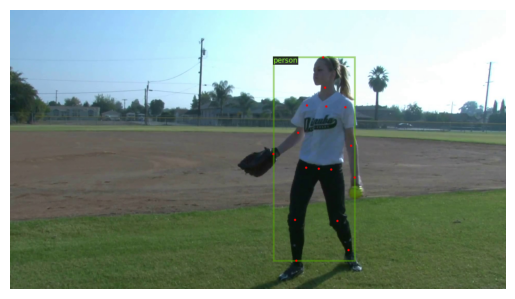

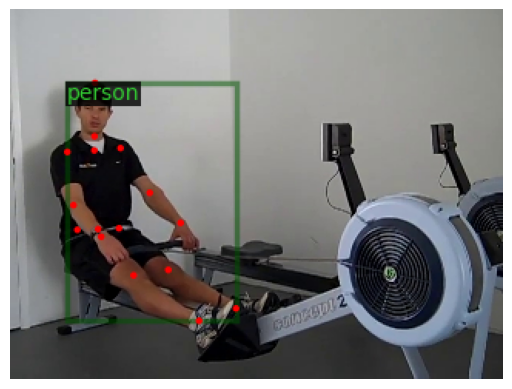

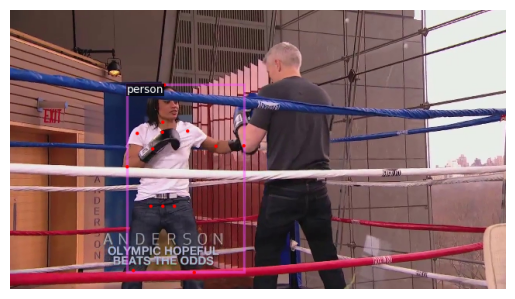

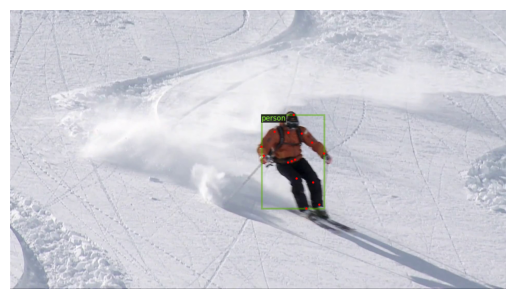

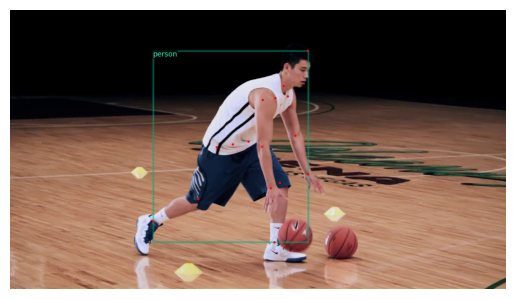

In [5]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt


dataset_dicts = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [6]:
import numpy as np

In [7]:
cfg = get_cfg() # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)
#cfg.SOLVER.STEPS = (200, 500, 1500)
cfg.SOLVER.GAMMA = 0.005
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((16, 1), dtype=float).tolist()

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # hand
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

In [8]:
import os
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/16 03:57:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[03/16 03:57:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Tr

[03/16 03:57:50 d2.utils.events]:  eta: 0:02:19  iter: 19  total_loss: 8.529  loss_cls: 0.1613  loss_box_reg: 0.2141  loss_keypoint: 8.154  loss_rpn_cls: 0.009259  loss_rpn_loc: 0.005841    time: 0.5014  last_time: 0.4733  data_time: 0.1721  last_data_time: 0.1442   lr: 0.0006427  max_mem: 8257M
[03/16 03:58:03 d2.utils.events]:  eta: 0:02:11  iter: 39  total_loss: 7.697  loss_cls: 0.1264  loss_box_reg: 0.1359  loss_keypoint: 7.429  loss_rpn_cls: 0.007276  loss_rpn_loc: 0.004783    time: 0.5094  last_time: 0.5366  data_time: 0.1713  last_data_time: 0.1850   lr: 0.0013087  max_mem: 8260M
[03/16 03:58:13 d2.utils.events]:  eta: 0:02:00  iter: 59  total_loss: 5.752  loss_cls: 0.08487  loss_box_reg: 0.1335  loss_keypoint: 5.534  loss_rpn_cls: 0.004779  loss_rpn_loc: 0.004457    time: 0.5060  last_time: 0.4682  data_time: 0.1590  last_data_time: 0.1340   lr: 0.0019747  max_mem: 8260M
[03/16 03:58:23 d2.utils.events]:  eta: 0:01:50  iter: 79  total_loss: 5.15  loss_cls: 0.08205  loss_box_reg

In [9]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
results = inference_on_dataset(trainer.model, val_loader, evaluator)

[03/16 04:00:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [03/16 04:00:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/16 04:00:20 d2.data.datasets.coco]: Loaded 169 images in COCO format from /content/val_annotations.json
[03/16 04:00:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/16 04:00:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/16 04:00:20 d2.data.common]: Serializing 169 elements to byte tensors and concatenating them all ...
[03/16 04:00:20 d2.data.common]: Serialized dataset takes 0.09 MiB
[03/16 04:00:20 d2.evaluation.evaluator]: Start inference on 169 batches
[03/16 04:00:21 d2.evaluation.evaluator]: Inference done 11/1

<ipython-input-5-bb6210cb36f4>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(), plt.imshow(im), plt.axis('off');


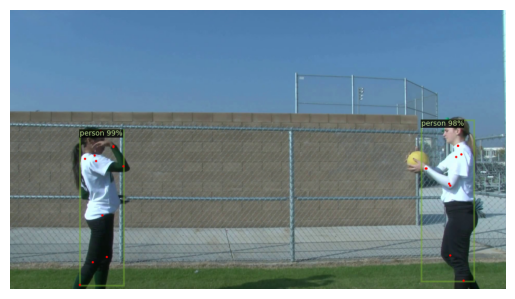

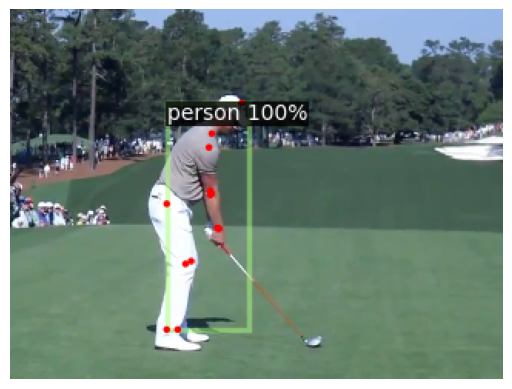

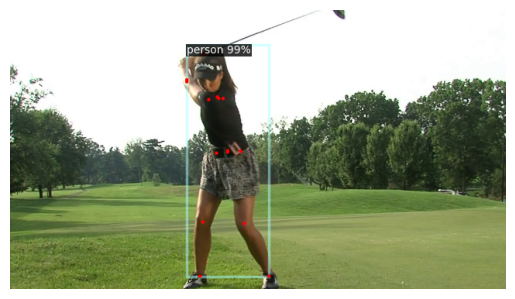

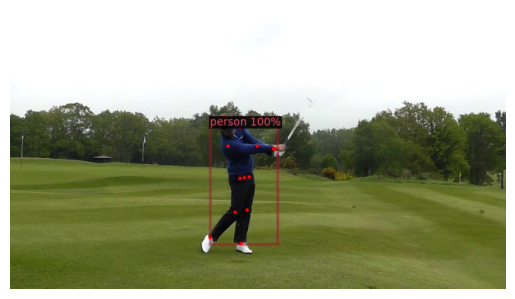

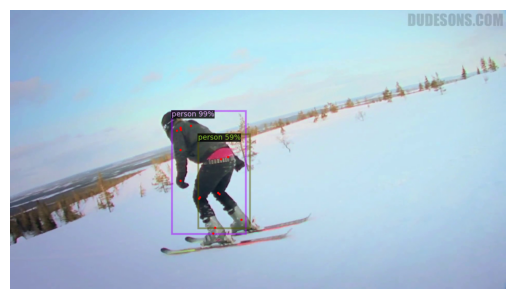

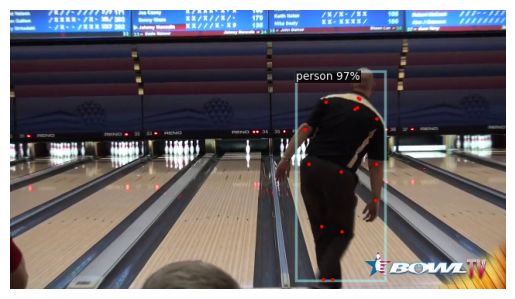

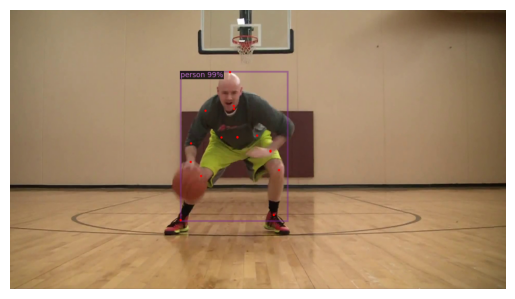

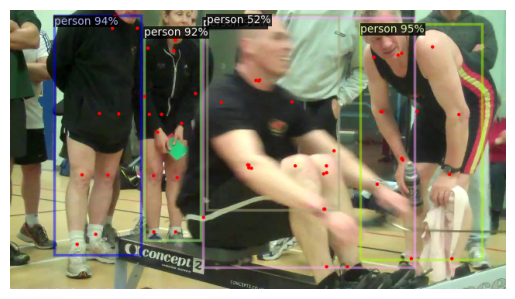

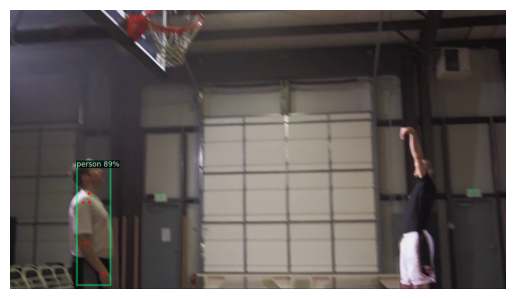

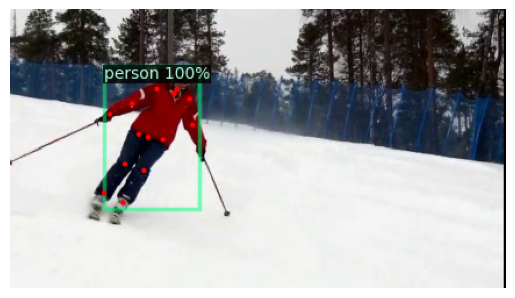

In [ ]:
from detectron2.utils.visualizer import Visualizer

# Visualize predictions for a few images
for i, input_data in enumerate(val_loader):
  image = cv2.imread(input_data[0]["file_name"])
  outputs = predictor(image)

  v = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

  cv2_imshow(out.get_image()[:, :, ::-1])
  cv2.waitKey(0)
  cv2.destroyAllWindows()